In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

In [2]:
def uncertainty(p_hat, var='sum'):
    p_mean = np.mean(p_hat, axis=0)
    ale = np.mean(p_hat*(1-p_hat), axis=0)
    epi = np.mean(p_hat**2, axis=0) - p_mean**2
    if var == 'sum':
        ale = np.sum(ale, axis=0)
        epi = np.sum(epi, axis=0)
    elif var == 'top':
        ale = ale[np.argmax(p_mean)]
        epi = epi[np.argmax(p_mean)]
    uncert = ale + epi
    return p_mean, uncert, ale, epi

In [3]:
labels = ['BG', 'A', 'K', 'L', 'P', 'Spl', 'Sto']
data = {
    'D1': {
        'BG': [0.57, 0.55, 0.56], 
        'A': [0.15, 0.17, 0.15],
        'K': [0.13, 0.12, 0.14],
        'L': [0.15, 0.16, 0.15],
        
    },
    'D2': {
        'BG': [0.82,0.83, 0.81], 
        'Sto': [0.18,0.17,0.19]
    },
    'D3': {
        'BG': [0.33,0.34,0.37], 
        'K': [0.1,0.06,0.11],
        'P': [0.06,0.06,0.05], 
        'Spl': [0.51,0.54,0.47], 
    }
}
logits = {d: np.array(list(p.values())).T for d, p in data.items()}
[np.sum(np.array([vv for vv in v.values()]), axis=0) for v in data.values()]

[array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.])]

In [4]:
preds_and_uncert = {d: uncertainty(l)[:2] for d, l in logits.items()}
uncerts = {d: u for d, (_,u) in preds_and_uncert.items()}
preds = {d: p for d, (p,_) in preds_and_uncert.items()}
preds = {d: {list(data[d])[i]: pp for i, pp in enumerate(p)} for d, p in preds.items()}

In [5]:
cp = {l: c for l, c in zip(labels[1:], sns.color_palette())}
cp['BG'] = 'gray'
uncert_color = sns.color_palette("rocket")[-4]

In [6]:
preds_new = []
for d, p in preds.items():
    p_new = np.zeros((len(labels),))
    for l, op in p.items():
        p_new[np.argwhere(np.array(labels)==l)[0,0]] = op
    preds_new.append(p_new)
vanilla_pred = np.array(preds_new)
vanilla_pred = vanilla_pred.sum(axis=0) / (vanilla_pred > 0).sum(axis=0)
mean_uncert = np.mean(list(uncerts.values()))

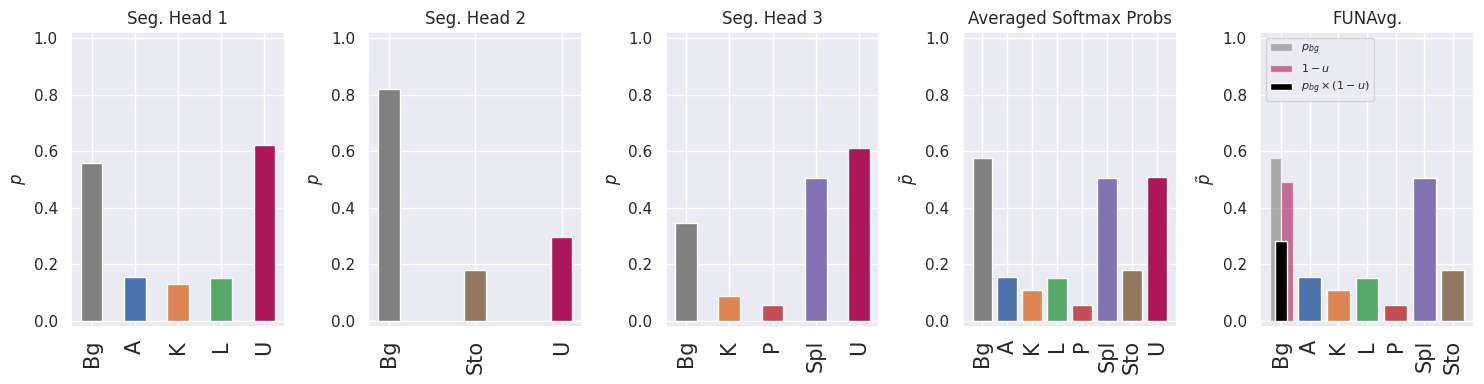

In [7]:
fig, axs = plt.subplots(1,5,figsize=(15,4))#,sharey=True)

for ax, (ds, p), w in zip(axs, preds.items(), [0.5, 0.25, 0.5]): # [0.8,0.8,0.8]): #
    for x, (k, op) in enumerate(p.items()):
        ax.bar(x, op, color=cp[k], width=w)
    ax.bar(x+1,uncerts[ds],color=uncert_color, width=w)
    ax.set_xticks(np.arange(len(p)+1))
    ax.set_xticklabels([o.capitalize() for o in p]+['U'],rotation=90,fontsize=15)
    ax.set_ylim([-0.02,1.02])
    ax.set_ylabel(r'$p$')
    
ax = axs[3]
for x, (l, p) in enumerate(zip(labels, vanilla_pred)):
    ax.bar(x, p, color=cp[l], width=0.8)
ax.bar(x+1,mean_uncert,color=uncert_color, width=0.8)
ax.set_xticks(np.arange(len(labels)+1))
ax.set_xticklabels([l.capitalize() for l in labels]+['U'],rotation=90,fontsize=15)
ax.set_ylim([-0.02,1.02])
ax.set_ylabel(r'$\tilde{p}$')

ax = axs[4]
ax.bar(-0.2, vanilla_pred[0], color=cp['BG'], width=0.4, alpha=0.6, label=r'$p_{bg}$')
for x, (l, p) in enumerate(zip(labels[1:], vanilla_pred[1:])):
    ax.bar(x+1, p, color=cp[l], width=0.8, alpha=1.0)
ax.bar(0.2,1-mean_uncert,color=uncert_color,alpha=0.6, width=0.4, label=r'$1-u$')
ax.bar(0,vanilla_pred[0]*(1-mean_uncert),color='black', width=0.4, label=r'$p_{bg} \times (1-u)$')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels([l.capitalize() for l in labels],rotation=90,fontsize=15)
ax.set_ylim([-0.02,1.02])
ax.set_ylabel(r'$\tilde{p}$')
ax.legend(loc='upper left', fontsize=8)

for ax, title in zip(axs, ['Seg. Head 1', 'Seg. Head 2', 'Seg. Head 3', 'Averaged Softmax Probs', 'FUNAvg.']):
    ax.set_title(title)

fig.tight_layout()
fig.savefig('method_funavg.png', bbox_inches='tight')